In [1]:
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit, train_test_split
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences
import keras_tuner as kt
import random
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras import regularizers
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Set the random seed for reproducibility
seed_value = 22
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

In [3]:
df=pd.read_csv("dataset.csv")

In [4]:
#sort by data 
df['day'] = pd.to_datetime(df['day'])
df = df.sort_values(by='day')

In [5]:
list_names = df['id'].unique()
len(df['id'].unique())

27

In [6]:
list_names = df['id'].unique()
train_names = list_names[:21]
val_names = list_names[21:24]
test_names = list_names[24:27]

In [7]:
window_size = 4 # parameter
X_all = []
y_all = []
subject_seq_ids = []

for subj in df['id'].unique():
    df_subj = df[df['id'] == subj].sort_values('day')
    features = df_subj.drop(columns=['id', 'day', 'target_mood', 'Unnamed: 0']).to_numpy() # Removed 'mood_class' from drop
    targets = df_subj['target_mood'].to_numpy() # Use target_mood directly

    for i in range(len(df_subj) - window_size):
        X_all.append(features[i:i+window_size])
        y_all.append(targets[i+window_size])
        subject_seq_ids.append(subj)

X_all = np.array(X_all)
y_all = np.array(y_all) # y_all is now the raw target_mood values
subject_seq_ids = np.array(subject_seq_ids)

train_ids = set(train_names)
val_ids = set(val_names)
test_ids = set(test_names)

train_mask = np.isin(subject_seq_ids, list(train_ids))
val_mask = np.isin(subject_seq_ids, list(val_ids))
test_mask = np.isin(subject_seq_ids, list(test_ids))

X_train = X_all[train_mask]
y_train = y_all[train_mask]

X_val = X_all[val_mask]
y_val = y_all[val_mask]

X_test = X_all[test_mask]
y_test = y_all[test_mask]

print("Train shape:", X_train.shape)
print("Val shape:", X_val.shape)
print("Test shape:", X_test.shape)

num_features = X_train.shape[2]


Train shape: (834, 4, 19)
Val shape: (99, 4, 19)
Test shape: (128, 4, 19)


In [8]:
"""scaler = StandardScaler()
#scaler = MinMaxScaler(feature_range=(-1, 1))

# Reshape X_train from 3D (sequences, window_size, features) to 2D (samples * window_size, features)
# for fitting the scaler. Each time step across all sequences becomes a sample for fitting.
X_train_reshaped = X_train.reshape(-1, num_features)

# Fit the scaler ONLY on the training data
scaler.fit(X_train_reshaped)

# Transform the training, validation, and test data using the fitted scaler
X_train_scaled_reshaped = scaler.transform(X_train_reshaped)
X_val_scaled_reshaped = scaler.transform(X_val.reshape(-1, num_features))
X_test_scaled_reshaped = scaler.transform(X_test.reshape(-1, num_features))

# Reshape the scaled data back to the original 3D sequence shape
X_train = X_train_scaled_reshaped.reshape(-1, window_size, num_features)
X_val= X_val_scaled_reshaped.reshape(-1, window_size, num_features)
X_test = X_test_scaled_reshaped.reshape(-1, window_size, num_features)

print("Scaled Train shape:", X_train.shape)
print("Scaled Val shape:", X_val.shape)
print("Scaled Test shape:", X_test.shape)"""

'scaler = StandardScaler()\n#scaler = MinMaxScaler(feature_range=(-1, 1))\n\n# Reshape X_train from 3D (sequences, window_size, features) to 2D (samples * window_size, features)\n# for fitting the scaler. Each time step across all sequences becomes a sample for fitting.\nX_train_reshaped = X_train.reshape(-1, num_features)\n\n# Fit the scaler ONLY on the training data\nscaler.fit(X_train_reshaped)\n\n# Transform the training, validation, and test data using the fitted scaler\nX_train_scaled_reshaped = scaler.transform(X_train_reshaped)\nX_val_scaled_reshaped = scaler.transform(X_val.reshape(-1, num_features))\nX_test_scaled_reshaped = scaler.transform(X_test.reshape(-1, num_features))\n\n# Reshape the scaled data back to the original 3D sequence shape\nX_train = X_train_scaled_reshaped.reshape(-1, window_size, num_features)\nX_val= X_val_scaled_reshaped.reshape(-1, window_size, num_features)\nX_test = X_test_scaled_reshaped.reshape(-1, window_size, num_features)\n\nprint("Scaled Train 

In [9]:
def build_model(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('units_lstm1', min_value=32, max_value=256, step=32),
                   return_sequences=True,
                   input_shape=(window_size, num_features)))
    model.add(Dropout(hp.Float('dropout_rate1', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(LSTM(units=hp.Int('units_lstm2', min_value=16, max_value=128, step=16)))
    model.add(Dense(units=hp.Int('units_dense', min_value=8, max_value=64, step=8),
                    activation='relu'))
    model.add(Dropout(hp.Float('dropout_rate2', min_value=0.05, max_value=0.4, step=0.05)))
    model.add(Dense(1)) # Output layer with 1 unit for regression (no activation by default)
    optimizer = hp.Choice('optimizer', values=['adam', 'rmsprop', 'sgd', 'nadam'])
    model.compile(optimizer=optimizer,
                  loss='mse', # Use Mean Squared Error for regression
                  metrics=['mae']) # Use Mean Absolute Error as a metric
    return model

In [10]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss', # Objective is validation loss (MSE in this case)
    max_trials=50,
    directory="my_dir",
    project_name="nn_tuning_regression" # Changed project name for clarity
     ,overwrite=True
)
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
################################################################################### HYPERPARAMTER TUNING ONLY FOR THE DEFAULT TRAININSDATA
tuner.search(
    X_train, y_train, # Use y_train (raw target_mood) for regression
    epochs=100,
    validation_data=(X_val, y_val), # Use y_val (raw target_mood) for regression
    callbacks=[stop_early],
    verbose=1)


Trial 50 Complete [00h 00m 11s]
val_loss: 0.5558728575706482

Best val_loss So Far: 0.3426896333694458
Total elapsed time: 00h 05m 56s


In [34]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best Hyperparameters Dictionary:", best_hps.values)

# Train the model with the best hyperparameters
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(X_train, y_train, epochs=40, batch_size=8, validation_data=(X_val, y_val)) # Use y_train and y_val

Best Hyperparameters Dictionary: {'units_lstm1': 192, 'dropout_rate1': 0.5, 'units_lstm2': 32, 'units_dense': 64, 'dropout_rate2': 0.4, 'optimizer': 'rmsprop'}
Epoch 1/40


C:\Users\youpz\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 13.8984 - mae: 2.9776 - val_loss: 0.7625 - val_mae: 0.5745
Epoch 2/40
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.0776 - mae: 1.1348 - val_loss: 0.7916 - val_mae: 0.5522
Epoch 3/40
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.7407 - mae: 1.0046 - val_loss: 0.4998 - val_mae: 0.5625
Epoch 4/40
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.7595 - mae: 1.0532 - val_loss: 0.4790 - val_mae: 0.5212
Epoch 5/40
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.5020 - mae: 0.9659 - val_loss: 0.6663 - val_mae: 0.6508
Epoch 6/40
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.7254 - mae: 1.0443 - val_loss: 0.6341 - val_mae: 0.6002
Epoch 7/40
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.5653 - mae: 0.9785 - val_loss: 0.3834 - val_mae: 0.4622
Epoch 8/40
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.4973 - mae: 0.9764 - val_loss: 0.4803 - val_mae: 0.5349
Epoch 9/40
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.5471

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step  
Mean Squared Error (MSE): 0.5186
Mean Absolute Error (MAE): 0.5626
R-squared (R2): 0.0401


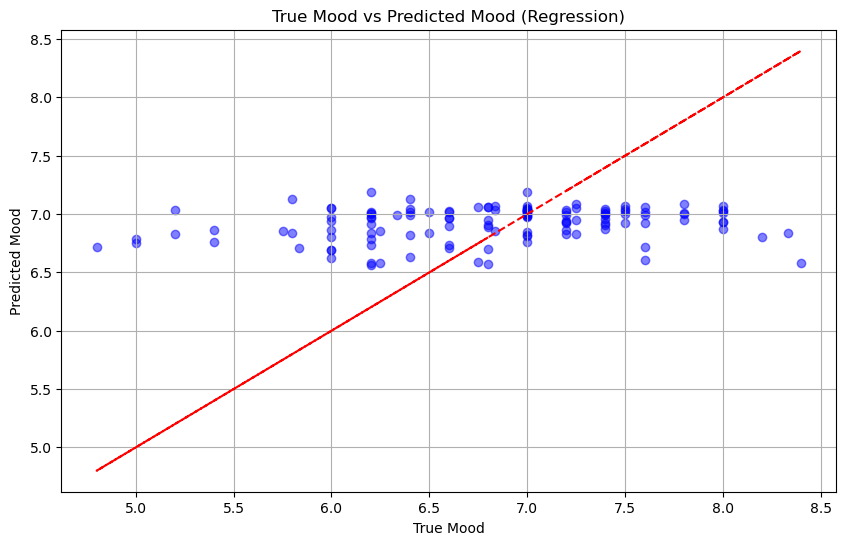

In [35]:
# Extract true labels (raw target_mood)
y_true = y_test

# Get predictions (y_pred will be continuous values for regression)
y_pred = best_model.predict(X_test).flatten() # Flatten the output to 1D array


mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R2): {r2:.4f}")


plt.figure(figsize=(10, 6))
plt.scatter(y_true, y_pred, color='blue', alpha=0.5)
plt.plot(y_true, y_true, color='red', linestyle='--') # Diagonal line for perfect predictions
plt.xlabel("True Mood")
plt.ylabel("Predicted Mood")
plt.title("True Mood vs Predicted Mood (Regression)")
plt.grid(True)
plt.show()